## Importando Librerias

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image



from modules import entrenamiento


## paraametros

In [2]:
epocas=2
#192
loteTrain=32
loteVal=32

In [3]:
obj= entrenamiento.TrainingModules()

In [4]:
obj.train_violent_dir = "../Database(5)/train/violencia/"
obj.train_non_violent_dir = "../Database(5)/train/no_violencia/"

obj.test_violent_dir = "../Database(5)/test/violencia/"
obj.test_non_violent_dir = "../Database(5)/test/no_violencia/"

## Definir el dispositivo de ejecucion (GPU si está disponible)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Se esta usando : ",device)

Se esta usando :  cuda:0


## Directorios de las imágenes

In [6]:

import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image

# Definir las transformaciones de aumento de datos
data_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor()
])

# Clase personalizada para aplicar las transformaciones a las imágenes
class CustomImageDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Crear el dataset utilizando las transformaciones de data augmentation
train_image_paths = [os.path.join(obj.train_violent_dir, img) for img in os.listdir(obj.train_violent_dir)] +                     [os.path.join(obj.train_non_violent_dir, img) for img in os.listdir(obj.train_non_violent_dir)]

train_labels = [1] * len(os.listdir(obj.train_violent_dir)) + [0] * len(os.listdir(obj.train_non_violent_dir))

train_dataset = CustomImageDataset(train_image_paths, train_labels, transform=data_transforms)

# Crear el DataLoader
train_loader = DataLoader(train_dataset, batch_size=loteTrain, shuffle=True)

# Similarmente, se puede definir para el conjunto de validación o test si fuera necesario


## Definiendo  algoritmos de muestreo 

In [7]:
# Definir el diccionario de muestreos

metodos = [
    "DataArgumentation"
]


## Cargar datos de entrenamiento

In [8]:
# Imprimir la ruta actual del script

X_train_violent, y_train_violent = obj.load_images_and_labels(obj.train_violent_dir, 1)
X_train_non_violent, y_train_non_violent = obj.load_images_and_labels(obj.train_non_violent_dir, 0)

X_train = np.concatenate((X_train_violent, X_train_non_violent), axis=0)
y_train = np.concatenate((y_train_violent, y_train_non_violent), axis=0)
## liberando memoria
del X_train_violent
del y_train_violent
del X_train_non_violent
del y_train_non_violent 

Inicindo proceso con el metodo:  DataArgumentation


Entrenando:  50%|█████     | 1/2 [00:01<00:01,  1.88s/iter]

Epoch [1/2], Train Loss: 0.1193, Train Acc: 96.14%, Val Loss: 0.0153, Val Acc: 99.74%


Entrenando: 100%|██████████| 2/2 [00:03<00:00,  1.80s/iter]

Epoch [2/2], Train Loss: 0.0038, Train Acc: 99.93%, Val Loss: 0.0034, Val Acc: 100.00%


Test Accuracy: 92.25%
Precision: 1.000000
Recall: 0.845070
F1 Score: 0.916031
G-Mean: 0.919277
Resultados guardados en ../resources/metricas/ResNet18_5_resultados_DataArgumentation.txt


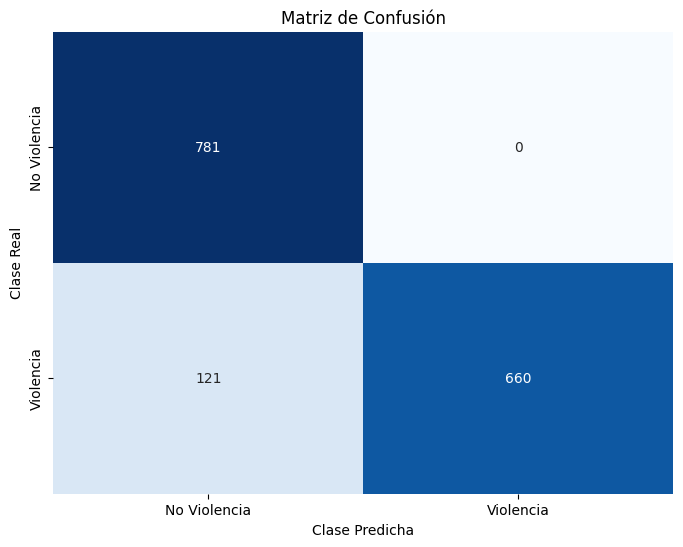

In [9]:
for mm in metodos:
    print("Inicindo proceso con el metodo: ",mm)
    X_sampled,y_sampled=obj.muestreo(X_train,y_train,mm)
    ## Dividir los datos de entrenamiento en entrenamiento y validación
    X_train_sampled, X_val, y_train_sampled, y_val = train_test_split(X_sampled, y_sampled, test_size=0.2, random_state=42)
    ## convertir a tensores
    train_inputs = torch.tensor(X_train_sampled, dtype=torch.float32).permute(0, 3, 1, 2)
    train_labels = torch.tensor(y_train_sampled, dtype=torch.long)
    val_inputs = torch.tensor(X_val, dtype=torch.float32).permute(0, 3, 1, 2)
    val_labels = torch.tensor(y_val, dtype=torch.long).to(device)  # Mover val_labels a la GPU
    ## vaciando variables para desocupar RAM
    del y_train_sampled
    del X_train_sampled
    del X_sampled
    del X_val
    del y_sampled
    del y_val 
    ### crear datasets y dataloaders
    train_dataset = TensorDataset(train_inputs, train_labels)
    val_dataset = TensorDataset(val_inputs, val_labels)
    train_loader = DataLoader(train_dataset, batch_size=loteTrain, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=loteVal, shuffle=True)  # DataLoader para validación
    ## liberando memoria


    del train_inputs 
    del train_labels 
    del val_inputs 
    del val_labels 
    ##
   
    ##
    model = obj.getModel()
    ##mover modelo a la gpu o en su defecto al cpu
    model = model.to(device) 
    ## se define el criterio de perdida y el otimizador 
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=0.001) 
    #optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4, weight_decay=1e-2)
    # Definir el optimizador Adam para las capas no congeladas
    #optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    optimizer = optim.Adam(model.parameters(), lr=0.001) 
    ################    Entrenamiento


    obj.fit(epocas,model,device,train_loader,val_loader,optimizer,criterion,len(train_dataset))
    #liberando memoria
    torch.cuda.empty_cache()
    del train_dataset
    del val_dataset 
    del val_loader 
    ########## guardar modelo

    torch.save(model.state_dict(), "../resources/modelos_Y_pesos/ResNet18_5"+mm+".pth")
    del optimizer
    del train_loader

    ###
    #       Test
    ###
    #cargar datos de prueba
    X_test_violent, y_test_violent = obj.load_images_and_labels(obj.test_violent_dir, 1)
    X_test_non_violent, y_test_non_violent = obj.load_images_and_labels(obj.test_non_violent_dir, 0)

    X_test = np.concatenate((X_test_violent, X_test_non_violent), axis=0)
    y_test = np.concatenate((y_test_violent, y_test_non_violent), axis=0)

    ##liberando memoria
    del X_test_violent
    del y_test_violent
    del X_test_non_violent
    del y_test_non_violent 
    #convertir a tensores
    test_inputs = torch.tensor(np.array(X_test), dtype=torch.float32).permute(0, 3, 1, 2)
    test_labels = torch.tensor(y_test, dtype=torch.long)

    ##crear dataset de eprueba
    test_dataset = TensorDataset(test_inputs, test_labels)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
    ###liberando memoria
    del test_inputs 
    del test_labels 
    del X_test 
    del y_test 

    ##evaluacion del conjunto de test
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, labels in test_loader:  
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    ## metricas para  conjuntos de test desbalanceados
    conf_matrix = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = conf_matrix.ravel()
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    gmean = np.sqrt(recall * (tn / (tn + fp)))  # G-Mean

    print(f"Test Accuracy: {100 * np.mean(np.array(y_true) == np.array(y_pred)):.2f}%")
    print(f"Precision: {precision:.6f}")
    print(f"Recall: {recall:.6f}")
    print(f"F1 Score: {f1:.6f}")
    print(f"G-Mean: {gmean:.6f}")

    # Nombre del archivo para guardar los resultados
    filename = "../resources/metricas/ResNet18_5_resultados_"+mm+".txt"

    # Guardar en archivo de texto
    with open(filename, 'w') as f:
        f.write(f"Test Accuracy: {100 * np.mean(np.array(y_true) == np.array(y_pred)):.2f}%\n")
        f.write(f"Precision: {precision:.4f}\n")
        f.write(f"Recall: {recall:.4f}\n")
        f.write(f"F1 Score: {f1:.4f}\n")
        f.write(f"G-Mean: {gmean:.4f}\n")

    print(f"Resultados guardados en {filename}")


    ## Matriz de confucion    
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=["No Violencia", "Violencia"], yticklabels=["No Violencia", "Violencia"])
    plt.xlabel("Clase Predicha")
    plt.ylabel("Clase Real")
    plt.title("Matriz de Confusión")
    plt.savefig("../resources/confusion_matrix/ResNet18_5"+mm+".png")
    plt.show()
    plt.close()